# Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

# Описание данных <a name="paragraph1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import requests
import bs4
import urllib.request
import re
from bs4 import BeautifulSoup
from io import BytesIO

In [2]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Вывод**

В нашем распоряжении оказались данные о заведениях общественного питания г. Москвы. Более 15тыс заведений.

Заметили, что в датасете отсуствуют пропуски и некорректные типы данных. 
Проверим датасет на наличие дубликатов и можно будет приступать к анализу данных 

# Предобработка данных <a name="paragraph2"></a>

## Дубликаты <a name="subparagraph1"></a>

In [4]:
# Выявили явные дупликаты (повторяется все кроме id). Находим 82 повторяющиеся строки
rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

82

Приведем названия всех заведений к нижнему регистру и перепроверим наличие дубликатов

In [5]:
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [6]:
rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

85

Удалим дубликаты из датасета

In [7]:
rest_data = rest_data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'])

In [8]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15281 non-null  int64 
 1   object_name  15281 non-null  object
 2   chain        15281 non-null  object
 3   object_type  15281 non-null  object
 4   address      15281 non-null  object
 5   number       15281 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.7+ KB


## Аномальные значения 

Изучим наш количественный показатель - количество посадочных мест 

In [9]:
rest_data['number'].describe()

count    15281.000000
mean        59.788234
std         74.843042
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [10]:
rest_data[rest_data['number'] == 0]['number'].count()

1588

In [11]:
rest_data[rest_data['number'] > 300]['number'].count()

123

Text(0, 0.5, 'Количество посадочных мест')

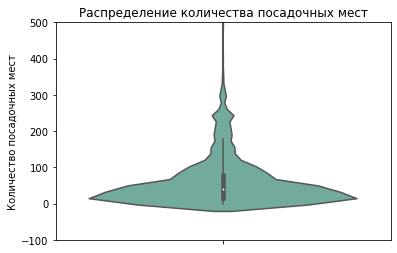

In [12]:
pic = sns.violinplot(y=rest_data["number"], color='#69b3a2')
pic.set_ylim(-100, 500)

pic.set_title("Распределение количества посадочных мест")
pic.set_xlabel('')
pic.set_ylabel('Количество посадочных мест')

**Вывод**

   * Удалили из датасета дубликаты
   * Изучили количественный показатель - кол-во посадочных мест
       * Медианное количество посадочных мест - 40. Уведели, что в датасете есть аномально большие показатели данного параметра. 3 квантиль - 80 посадочных мест. Макс значение - 1700 посадочных мест. Решаем оставить аномальные значения в датасете, так как это могут быть значимые/популярные заведения общственного питания
       

# Исследовательская часть <a name="paragraph3"></a>

## Соотношение видов объектов общественного питания по количеству


Сгруппируем данные по типу объекта (кафе, ресторан, столовая и тд) и построим столбчатую диаграмму

In [13]:
objects = rest_data.groupby('object_type')['id'].count().reset_index().sort_values(by='id', ascending=False)
objects

,object_type,id
3,кафе,6071
8,столовая,2584
7,ресторан,2282
6,предприятие быстрого обслуживания,1897
0,бар,855
1,буфет,576
4,кафетерий,395
2,закусочная,348
5,магазин (отдел кулинарии),273


Text(0, 0.5, 'Тип объекта общественного питания')

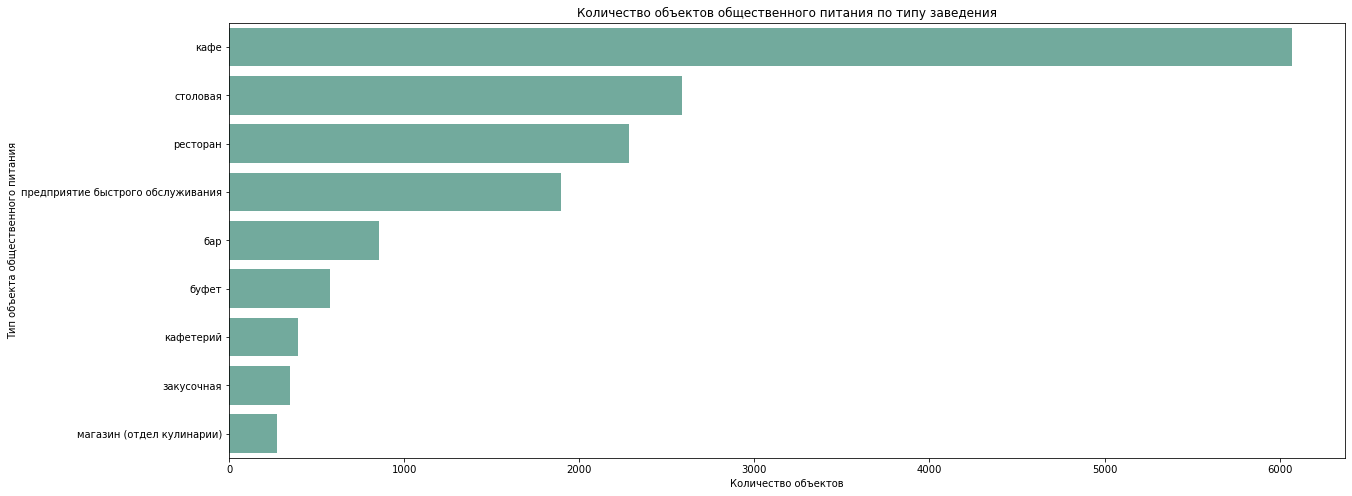

In [14]:
#Устанавливаем размер графика
plt.figure(figsize=(20, 8))

#Строим barplot
object_types_by_num = sns.barplot(
    x="id", 
    y='object_type',
    data=objects,
    color='#69b3a2',
    ci=None);

# Название графика и осей

object_types_by_num.set_title("Количество объектов общественного питания по типу заведения")
object_types_by_num.set_xlabel('Количество объектов')
object_types_by_num.set_ylabel('Тип объекта общественного питания')

**Вывод**

Всего в выборке наблюдаем 9 типов заведений:
   
   * Кафе
   * Столовая
   * Ресторан
   * Предприятие быстрогоо обслуживания
   * Бар
   * Буфет
   * Кафетерий
   * Закусочная
   * Магазин (отдел кулинарии)
   

С большим отрывом (более чем в 2 раза) лидируют "Кафе" - более 6тыс заведений.
В выборке также встречается более 2тыс столовых и ресторанов и чуть меньше 2 тыс предприятий быстрого обслуживания.

Остальные типы заведений встречаются 1тыс и менее раз 

## Соотношение сетевых и несетевых заведений по количеству


In [15]:
chains = rest_data.groupby('chain')['id'].count().reset_index()
chains

,chain,id
0,да,2964
1,нет,12317


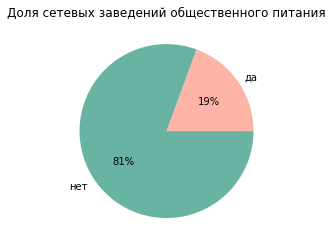

In [84]:
#Создаем pie chart

plt.pie(chains['id'], labels = chains['chain'], colors = ['#fdb4a7', '#69b3a2'], autopct='%.0f%%')
plt.title("Доля сетевых заведений общественного питания")
plt.show()

**Вывод**

Около 20% выборки относится к сетевым заведениям 

## Виды объектов общественного питания с сетевым распространением

Выявить для какого вида объекта общественного питания характерно сетевое распространение. Для этого создадим срез, в котором останутся только сетевые заведения, произведем группировку по типу объекта и потроим график


In [17]:
chained_objects = rest_data[rest_data['chain'] == 'да'].groupby(
    'object_type')['id'].count().reset_index().sort_values(by='id', ascending=False).head(10)
chained_objects

,object_type,id
3,кафе,1396
6,предприятие быстрого обслуживания,788
7,ресторан,543
5,магазин (отдел кулинарии),78
2,закусочная,56
4,кафетерий,52
0,бар,37
1,буфет,11
8,столовая,3


Text(0.5, 0, 'Количество объектов')

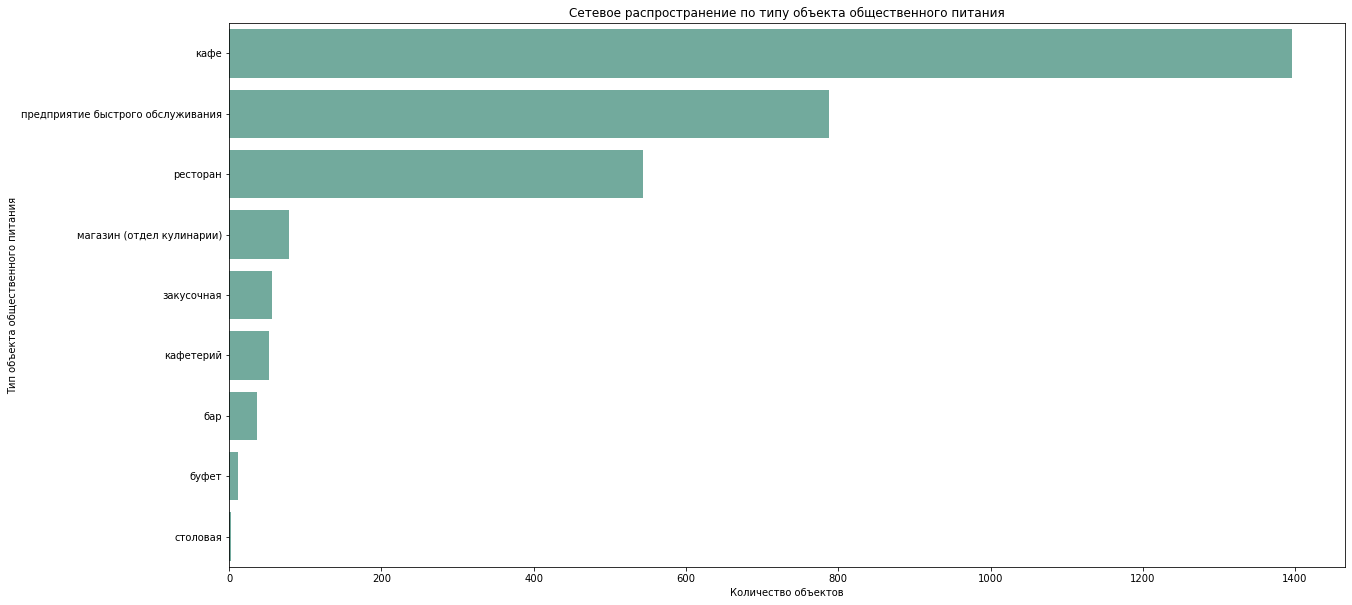

In [18]:
# Устанавливаем размер графика
plt.figure(figsize=(20, 10))

# Строим barplot
a = sns.barplot(
    x="id", 
    y='object_type',
    data= chained_objects,
    color='#69b3a2', ci=None)

# Название графика и осей
a.set_title("Сетевое распространение по типу объекта общественного питания")
a.set_ylabel("Тип объекта общественного питания")
a.set_xlabel('Количество объектов')


Топ наименований сетевых заведений с наибольшим количеством точек в Москве

In [19]:
chained_id_count = rest_data[rest_data['chain'] == 'да'].groupby('object_name')['id'].count().sort_values(ascending=False).reset_index().head(10)
chained_id_count


,object_name,id
0,шоколадница,157
1,kfc,155
2,макдоналдс,150
3,бургер кинг,137
4,теремок,94
5,крошка картошка,90
6,домино'с пицца,90
7,милти,72
8,суши wok,72
9,папа джонс,51


Text(0.5, 0, 'Количество объектов')

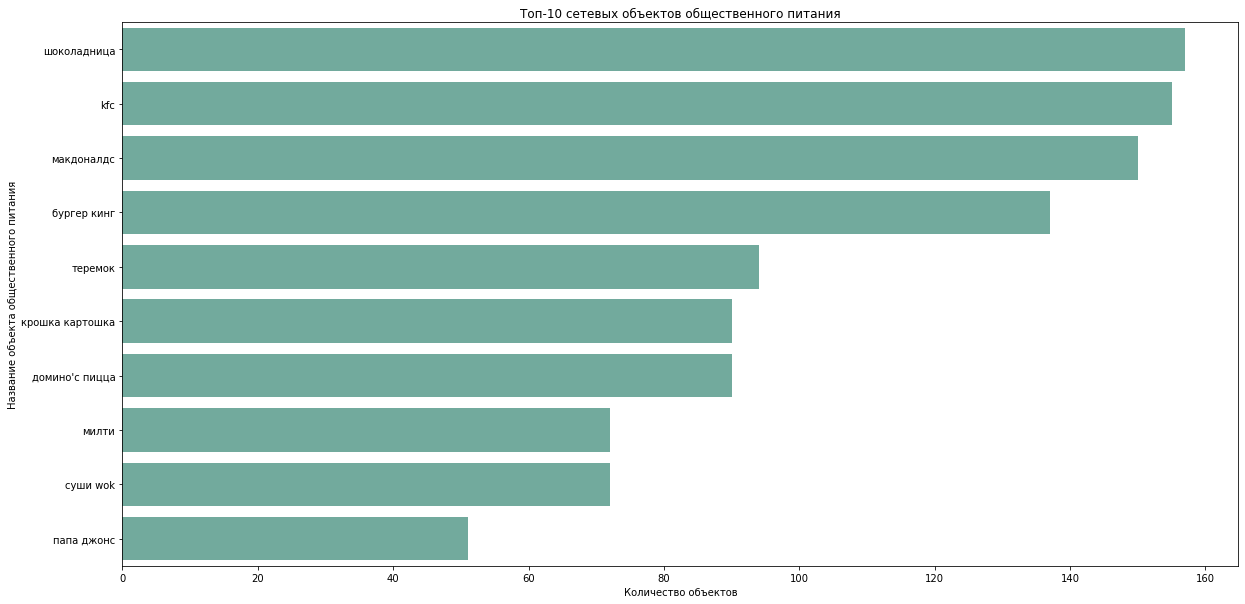

In [20]:
# Устанавливаем размер графика
plt.figure(figsize=(20, 10))

# Строим barplot
best_chain = sns.barplot(
    x="id", 
    y='object_name',
    data= chained_id_count,
    color='#69b3a2',
    ci=None)

# Название графика и осей
best_chain.set_title("Топ-10 сетевых объектов общественного питания")
best_chain.set_ylabel("Название объекта общественного питания")
best_chain.set_xlabel('Количество объектов')


Добавила в датасет новый столбец с числовым типом данный, отображащий принадлежность заведения к сети. 

Если заведение сетевое, значение равно 1

Если несетевое - 0

In [21]:
def int_chains(chain):
    if chain == 'да':
        return 1
    else:
        return 0
    
    
rest_data['int_chains'] = rest_data['chain'].apply(int_chains)
rest_data.head()    

,id,object_name,chain,object_type,address,number,int_chains
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,0
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,0
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,0
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,1
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,0


Группируем заведения по типу объекта и считаем среднее значение по новой колонке. 

Чем ближе среднее значение к 1, тем больше процент сетевых заведений среди конкретного типа заведений.

In [22]:
rest_data.groupby('object_type')['int_chains'].mean().reset_index().sort_values(by='int_chains', ascending=False)

,object_type,int_chains
6,предприятие быстрого обслуживания,0.415393
5,магазин (отдел кулинарии),0.285714
7,ресторан,0.237949
3,кафе,0.229946
2,закусочная,0.160920
4,кафетерий,0.131646
0,бар,0.043275
1,буфет,0.019097
8,столовая,0.001161


**Вывод**

Больше всего сетевое распространение характерно для:

   * Предприятий быстрого обсулживания - более 40% таких заведений являются сетевыми 
   * Магазинов (отделов кулинарии) - 29%
   * Ресторанов - 24%
   * Кафе - 23%

Чаще всего в выборке сетевые заведения представлены типами "кафе" (1396), "предприятие быстрого обсулуживания" (791) и "ресторан" (544)

Топ-10 составляют известные сети предприятий быстрого питания - КФС, Макдоналдс, Бургер Кинг. Также распространены заведения по доставке суши и пиццы. Возглавляет топ крупнейшая в Москве сеть кафе Шоколадница.

## Характеристика сетевых заведений

Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Делаем срез, оставляем только сетевые заведения. Группируем датасет по названию объекта и находим
   * кол-во заведений сети
   * общее кол-во посадочных мест сети

In [23]:
chained_id_count = rest_data[rest_data['chain'] == 'да'].groupby('object_name')['id'].count().reset_index()
chained_seats_count = rest_data[rest_data['chain'] == 'да'].groupby('object_name')['number'].sum().reset_index()

Добавляем параметр `number_per_obj` - среднее количество посадочных мест для одного филиала конкретной сети

In [24]:
chained_obj = chained_id_count.merge(chained_seats_count).sort_values(by='id', ascending=False)
chained_obj['number_per_obj'] = chained_obj['number'] / chained_obj['id']
# Почему-то к сетевым заведениям попали сети, которым принадлежит только одна точка.
# Отфильтровываем такие объекты, чтобы они не портили анализ 
chained_obj = chained_obj[chained_obj['id'] != 1].reset_index(drop=True) 
chained_obj.head(10)

,object_name,id,number,number_per_obj
0,шоколадница,157,8978,57.184713
1,kfc,155,8578,55.341935
2,макдоналдс,150,13155,87.700000
3,бургер кинг,137,6391,46.649635
4,теремок,94,2407,25.606383
5,крошка картошка,90,1967,21.855556
6,домино'с пицца,90,1651,18.344444
7,милти,72,96,1.333333
8,суши wok,72,483,6.708333
9,папа джонс,51,1124,22.039216


Определимся, что означает "большое количество посадочных мест" и "много заведений сети".


Изучим подробнее сколько филиалов входят в одну сеть. Медианное значение - 4 заведения

In [25]:
chained_obj['id'].describe()

count    246.000000
mean      10.703252
std       22.638719
min        2.000000
25%        2.000000
50%        4.000000
75%        7.000000
max      157.000000
Name: id, dtype: float64

Медианное значение кол-ва посадочных мест - 44

In [26]:
chained_obj['number_per_obj'].describe()

count    246.000000
mean      59.396081
std       49.548665
min        0.000000
25%       21.125000
50%       44.000000
75%       85.000000
max      258.666667
Name: number_per_obj, dtype: float64

Медианное количество заведений в сети - 4 шт. Будем считать, что более 4 филиалов сети -  "много заведений".
Медианное количество посадочных мест в нашей выборке сетевых заведений -  44. Будем считать, что "большое количество посадочных мест" должно превышать 44 посадочных места. 

Разделим сети на 4 группы:
   * "broad chain" и "high number of seats" - группа 1
   * "broad chain" и "small number of seats" - группа 2
   * "small chain" и "high number of seats" - группа 3
   * "small chain" и "small number of seats" - группа 4

При помощи метода `cut` разделим датасет на группы, во-первых, `broad chain` или `small chain`, во-вторых, `high number of seats` или `small number of seats`

In [27]:
chained_obj['obj_frequency'] = pd.cut(
    chained_obj['id'],bins=[0,4,157],labels=['small chain','broad chain']
)
chained_obj['number_levels'] = pd.cut(
    chained_obj['number_per_obj'], bins=[0, 44, 260], labels=['small number of seats', 'high number of seats']
)
chained_obj

,object_name,id,number,number_per_obj,obj_frequency,number_levels
0,шоколадница,157,8978,57.184713,broad chain,high number of seats
1,kfc,155,8578,55.341935,broad chain,high number of seats
2,макдоналдс,150,13155,87.700000,broad chain,high number of seats
3,бургер кинг,137,6391,46.649635,broad chain,high number of seats
4,теремок,94,2407,25.606383,broad chain,small number of seats
...,...,...,...,...,...,...
241,кафе «costa coffee»,2,41,20.500000,small chain,small number of seats
242,изба,2,35,17.500000,small chain,small number of seats
243,зодиак,2,144,72.000000,small chain,high number of seats
244,закусочная «бургер кинг»,2,40,20.000000,small chain,small number of seats


Группируем по этим двум категориям (кол-во заведений в сети и кол-во посадочных мест на одно заведение сети)

In [28]:
chained_obj.groupby(['obj_frequency', 'number_levels'])['object_name'].count().reset_index().sort_values(by='object_name')

,obj_frequency,number_levels,object_name
3,broad chain,high number of seats,51
2,broad chain,small number of seats,58
0,small chain,small number of seats,61
1,small chain,high number of seats,71


In [29]:
chained_obj['category'] = chained_obj[['obj_frequency','number_levels']].apply(lambda s : (s[0],s[1]), axis=1)

Text(0.5, 0, 'Количество объектов в сети')

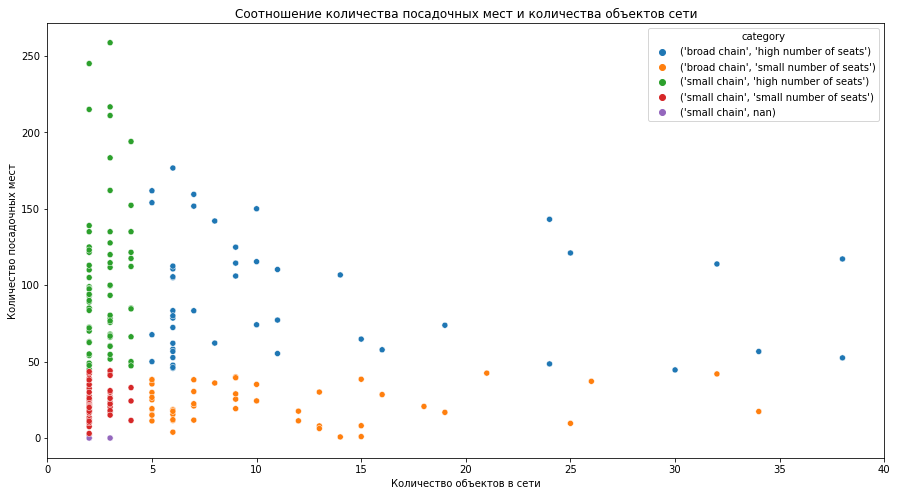

In [30]:
# Устанавливаем размер графика
plt.figure(figsize=(15, 8))

# Строим диаграмму рассеяния
# scatterplot = sns.regplot(x=chained_obj["id"], y=chained_obj["number_per_obj"], color='#69b3a2', fit_reg=False, hue='category')

scatterplot = sns.scatterplot(data=chained_obj,x="id", y="number_per_obj", color='#69b3a2', hue='category')

#scatterplot.set(ylim=(0, 250))
scatterplot.set(xlim=(0, 40))

scatterplot.set_title("Соотношение количества посадочных мест и количества объектов сети")
scatterplot.set_ylabel("Количество посадочных мест")
scatterplot.set_xlabel('Количество объектов в сети')

**Вывод**


Видим, что у сетей с малым кол-ом точек довольно большое и медианное количество посадочных мест, и также большой разброс посадочных мест. Макс достигает 258 мест.   
С другой стороны, сетей с большим количеством точек намного меньше. 



## Cреднее количество посадочных мест 

 Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

Группируем датасет по типу объекта и находим среднее количество посадочных мест. Сохраняем в датафрейм `avg_number_by_type`

In [31]:
avg_number_by_type = rest_data.groupby('object_type')['number'].mean().reset_index().sort_values(by='number', ascending=False)
avg_number_by_type

,object_type,number
8,столовая,130.337848
7,ресторан,96.884750
1,буфет,51.425347
0,бар,43.533333
3,кафе,39.785703
6,предприятие быстрого обслуживания,20.808645
4,кафетерий,9.184810
2,закусочная,7.847701
5,магазин (отдел кулинарии),5.589744


Text(0.5, 0, 'Среднее количество посадочных мест')

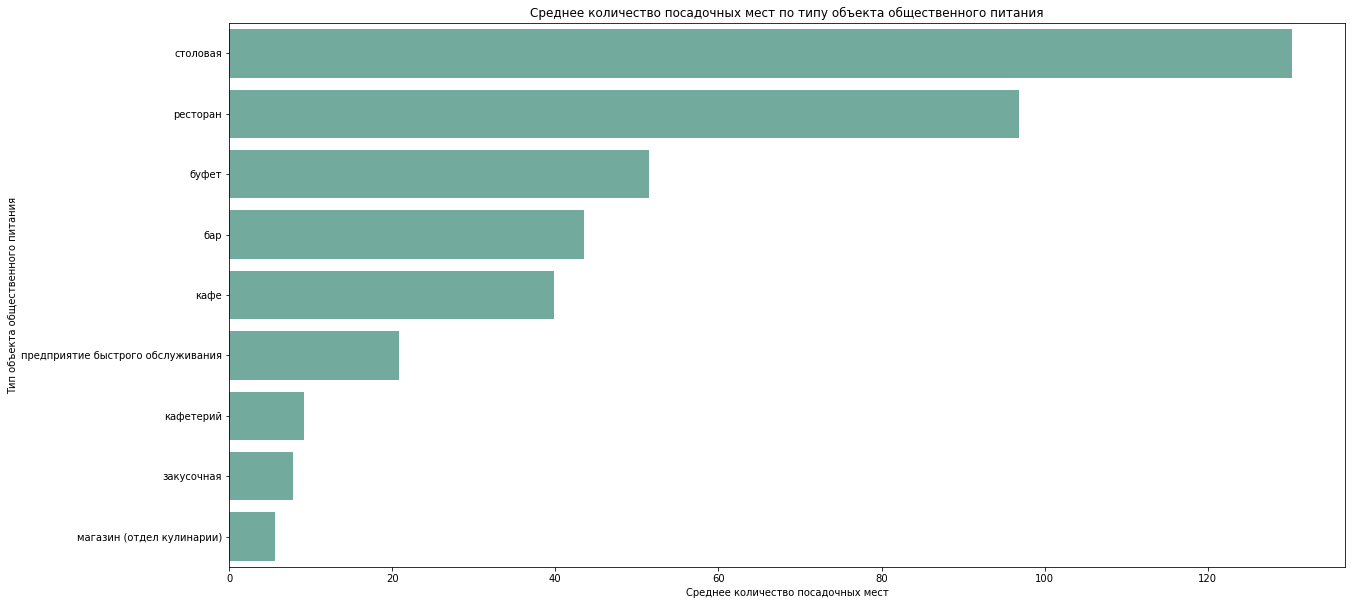

In [32]:
# Устанавливаем размер графика
plt.figure(figsize=(20, 10))

# Строим barplot
a = sns.barplot(
    x="number", 
    y='object_type',
    data= avg_number_by_type,
    color='#69b3a2',
    ci=None)

# Название графика и осей
a.set_title("Среднее количество посадочных мест по типу объекта общественного питания")
a.set_ylabel("Тип объекта общественного питания")
a.set_xlabel('Среднее количество посадочных мест')


**Вывод**

Больше всего посадочных мест в среднем в Столовых (130) и ресторанах (96). Среднее кол-во посадочных мест в кафе - 40
   

## Добавить столбец с названием улицы


Из столбца с адресом выделим нужную нам часть (с названием улицы) используя ключевые слова. Для этого пишем функцию

Cписок ключевых слов взят с сайта mosopen, раздел Типы Московских улиц. Ссылка - http://mosopen.ru/streets. 
Далее добавлены слова, которые не входили в этот список таким образом, чтобы у всех объектов датасета получилось выделить названия улиц


In [33]:
def streets(address):
    streets_names = [
        'улица','проспект','шоссе','проезд','бульвар','переулок','набережная','площадь','вал','аллея', "квартал", "линия", "просек", "тупик", 'микрорайон', 'Зеленоград', 'поселение', "километр", "территория", "посёлок"] 
    sp = address.split(', ')
    for index in streets_names:
        for x in sp:
           if index in x:
            return x
              

Применяем функцию к столбцу с адресом

In [34]:
rest_data['street'] = rest_data['address'].apply(streets) 

Приводим названия улиц к единому формату - нижний регистр + избавляемся от указания `улица, проспект, шоссе и тд`

In [35]:
rest_data['clean_street'] = rest_data['street'].str.replace('улица|проспект|шоссе|проезд|бульвар|набережная|площадь|вал|аллея|переулок|квартал|линия|просек|тупик|микрорайон|Зеленоград|поселение|километр|территория|посёлок|,|1-я|2-я|3-я|4-я|5-я|1-й|2-й|3-й|4-й|5-й|9-я|7-я', '').str.strip().str.lower()

<ipython-input-35-71581bd85a0b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  rest_data['clean_street'] = rest_data['street'].str.replace('улица|проспект|шоссе|проезд|бульвар|набережная|площадь|вал|аллея|переулок|квартал|линия|просек|тупик|микрорайон|Зеленоград|поселение|километр|территория|посёлок|,|1-я|2-я|3-я|4-я|5-я|1-й|2-й|3-й|4-й|5-й|9-я|7-я', '').str.strip().str.lower()


In [36]:
rest_data.head(10)

,id,object_name,chain,object_type,address,number,int_chains,street,clean_street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,0,улица Егора Абакумова,егора абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,0,улица Талалихина,талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,0,Абельмановская улица,абельмановская
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,1,Абрамцевская улица,абрамцевская
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,0,Абрамцевская улица,абрамцевская
5,27429,стол. при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240,0,Абрамцевская улица,абрамцевская
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,1,переулок Сивцев Вражек,сивцев вражек
7,20957,буфет мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90,0,Авиамоторная улица,авиамоторная
8,20958,кпф семья-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150,0,Авиамоторная улица,авиамоторная
9,28858,столовая мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120,0,Авиамоторная улица,авиамоторная


## Топ-10 улиц по количеству объектов общественного питания 
Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы.
Начнем с поиска информации о районах Москвы

### Парсинг данных о районах Москвы  

Воспользуемся сайтом MosOpen.ru, на котором размещена информация об улицах с разбивкой по районам Москвы.  
Для извлечения необходимых данных с HTML страницы будем использовать пакет Beautiful Soup. 

Для начала откроем страницу с названиями районов Москвы.

In [37]:
url = 'http://mosopen.ru/streets'
reqt = requests.get(url)
reqt

<Response [200]>

In [38]:
parser = bs4.BeautifulSoup(reqt.text, 'lxml')

In [39]:
parser

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xml:lang="ru" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>Улицы Москвы - Электронная Москва</title>
<meta content="Список всех улиц, расположенных на территории города Москвы" name="Description"/>
<meta content="улицы Москвы,улицы города Москвы,улицы онлайн,карта улиц Москвы,названия улиц,найти улицу,улицы онлайн смотреть,улицы по районам,улицы по округам,схема улиц Москвы,новые улицы Москвы,карта улиц,справочник улиц,адреса улиц,Москва" name="Keywords"/>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<link href="http://mosopen.ru/favicon.ico" rel="shortcut icon"/>
<link href="http://mosopen.ru/public/styles/structure.css" rel="stylesheet" type="text/css"/>
<script charset="utf-8" src="http://mosopen.ru/public/scripts/jquery.js" type="text/javascript"></script>
<script charset="utf-8" src="http://mosopen.ru/public/scripts/common.js" type="tex

Пробегаемся по коду и находим кусок, в котором находится название района и ссылка на страницу соответствующего района с нзваниями всех улиц.
 
 Пример:
 `<a href="http://mosopen.ru/region/akademicheskij/streets" title="Улицы Академического района">Академический</a>,<br/>`


Замечаем, что все ссылки с районами начинаются с `http://mosopen.ru/region/`. Однако, на странице эти ссылки встречаются несколько раз, поэтому после парсинга необходимо будет удалить дубликаты. 

Создаем список `links`, в который собираем все подходящие нам ссылки. Также создаем список `region_names`, в который собираем все названия районов.

Далее объеденяем их в один датафрейм `df`

In [40]:
links = []
region_names = []

for link in parser.findAll('a', attrs={'href': re.compile("^http://mosopen.ru/region/")}):
    links.append(link.get('href'))  
    region_names.append(link.next_element)

    
links_1 = pd.Series(links, name='reg_link')
reg_names_1 = pd.Series(region_names, name='reg_name')    

In [41]:
links_1

0       http://mosopen.ru/region/akademicheskij/streets
1         http://mosopen.ru/region/alekseevskij/streets
2          http://mosopen.ru/region/altufevskij/streets
3                http://mosopen.ru/region/arbat/streets
4             http://mosopen.ru/region/aeroport/streets
                             ...                       
245           http://mosopen.ru/region/kryukovo/streets
246         http://mosopen.ru/region/matushkino/streets
247            http://mosopen.ru/region/savelki/streets
248             http://mosopen.ru/region/silino/streets
249    http://mosopen.ru/region/staroe_kryukovo/streets
Name: reg_link, Length: 250, dtype: object

In [42]:
reg_names_1

0       Академический
1        Алексеевский
2        Алтуфьевский
3               Арбат
4            Аэропорт
            ...      
245           Крюково
246         Матушкино
247           Савёлки
248            Силино
249    Старое Крюково
Name: reg_name, Length: 250, dtype: object

Объединяем серии в один датафрейм, удаляем дубликаты

In [43]:
df = reg_names_1.to_frame().join(links_1).drop_duplicates().reset_index(drop=True)
df

,reg_name,reg_link
0,Академический,http://mosopen.ru/region/akademicheskij/streets
1,Алексеевский,http://mosopen.ru/region/alekseevskij/streets
2,Алтуфьевский,http://mosopen.ru/region/altufevskij/streets
3,Арбат,http://mosopen.ru/region/arbat/streets
4,Аэропорт,http://mosopen.ru/region/aeroport/streets
...,...,...
120,Щукино,http://mosopen.ru/region/shchukino/streets
121,Южнопортовый,http://mosopen.ru/region/yuzhnoportovyj/streets
122,Якиманка,http://mosopen.ru/region/yakimanka/streets
123,Ярославский,http://mosopen.ru/region/yaroslavskij/streets


С применением цикла проходимся по всем ссылкам районов и парсим оттуда названия улиц, ссылку на страницу (будем использовать как id района). Дополнительно соберем информацию о том, к какому округу относится район. Объединяем все в один датафрейм

In [44]:
str_name = []
dist_name = []
link = []

for i in df['reg_link']:
    html_page = urllib.request.urlopen(i)
    soup = BeautifulSoup(html_page, "html.parser")
    for street in soup.findAll('a', attrs={'href': re.compile("^http://mosopen.ru/street/")}):
        str_name.append(street.next_element)
        link.append(i)
        a = soup.find(href = re.compile("^http://mosopen.ru/district/"))
        dist_name.append(a.next_element)
        

In [45]:
str_name_2 = pd.Series(str_name, name='street_name')
links_2 = pd.Series(link, name='reg_link')   
dist_name_2 = pd.Series(dist_name, name='dist_name')

In [46]:
df_2 = str_name_2.to_frame().join(links_2).join(dist_name_2)
df_2

,street_name,reg_link,dist_name
0,"60-летия Октября, проспект",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО
1,Большая Черёмушкинская улица,http://mosopen.ru/region/akademicheskij/streets,ЮЗАО
2,"Вавилова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО
3,"Винокурова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО
4,"Гримау, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО
...,...,...,...
4183,Соловьиный проезд,http://mosopen.ru/region/yasenevo/streets,ЮЗАО
4184,Тарусская улица,http://mosopen.ru/region/yasenevo/streets,ЮЗАО
4185,Тютчевская аллея,http://mosopen.ru/region/yasenevo/streets,ЮЗАО
4186,"Узкое, посёлок",http://mosopen.ru/region/yasenevo/streets,ЮЗАО


Объединяем с ранее созданным датафреймом `df` по ссылке на веб страницу (в данном случае ссылка выступает в роли id района).
Получаем итоговую таблицу с названием улицы и соответсвующим ей районом Москвы.

In [47]:
street_district = pd.merge(left = df_2, right = df, how = 'left', on = 'reg_link')

Для дальнейшего объединения нового датафрейма с нашим изначальных необходимо привести названия улиц к единому формату. 
Избавляемся от слов `'улица','проспект','шоссе' и тд` и приводим все к нижнему регистру. 

In [48]:
street_district['clean_street'] = street_district['street_name'].str.replace(
    'улица|проспект|шоссе|проезд|бульвар|набережная|площадь|вал|аллея|переулок|квартал|линия|просек|тупик|микрорайон|Зеленоград|поселение|километр|территория|посёлок|,|1-я|2-я|3-я|4-я|5-я|1-й|2-й|3-й|4-й|5-й|9-я|7-я', ''
).str.strip().str.lower()
street_district

<ipython-input-48-1b3f0c3de058>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  street_district['clean_street'] = street_district['street_name'].str.replace(


,street_name,reg_link,dist_name,reg_name,clean_street
0,"60-летия Октября, проспект",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,60-летия октября
1,Большая Черёмушкинская улица,http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,большая черёмушкинская
2,"Вавилова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,вавилова
3,"Винокурова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,винокурова
4,"Гримау, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,гримау
...,...,...,...,...,...
4183,Соловьиный проезд,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,соловьиный
4184,Тарусская улица,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,тарусская
4185,Тютчевская аллея,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,тютчевская
4186,"Узкое, посёлок",http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,узкое


Группируем датасет по названию улиц и считаем количество регионов для каждой улицы

In [49]:
reg_num = street_district.groupby('clean_street')['reg_name'].count().reset_index()
reg_num

,clean_street,reg_name
0,1 мая,1
1,10-летия октября,1
2,1812 года,1
3,1905 года,1
4,40 лет октября,1
...,...,...
3000,яузская,2
3001,яузские ворота,1
3002,яузский,1
3003,яхромская,1


Создаем в датасете новый столбец `reg_number`, в котором отмечается ко скольким районам относится улица

In [50]:
street_district = street_district.merge(reg_num, how='left', on='clean_street')
street_district = street_district.rename(columns={'reg_name_y': 'reg_number', 'reg_name_x':'reg_name'})

street_district.head()

,street_name,reg_link,dist_name,reg_name,clean_street,reg_number
0,"60-летия Октября, проспект",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,60-летия октября,2
1,Большая Черёмушкинская улица,http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,большая черёмушкинская,2
2,"Вавилова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,вавилова,4
3,"Винокурова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,винокурова,2
4,"Гримау, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,гримау,1


Оставляем датасет `street_district` в сохранности на тот случай, если будет необходимо получить все наименования районов для каждой улицы

Сохраняем в датасет `wout_duplic_streets` данные из `street_district`, удалив повторяющиеся улицы

In [51]:
wout_duplic_streets = street_district.drop_duplicates(subset=['clean_street']).reset_index(drop=True)
wout_duplic_streets

,street_name,reg_link,dist_name,reg_name,clean_street,reg_number
0,"60-летия Октября, проспект",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,60-летия октября,2
1,Большая Черёмушкинская улица,http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,большая черёмушкинская,2
2,"Вавилова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,вавилова,4
3,"Винокурова, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,винокурова,2
4,"Гримау, улица",http://mosopen.ru/region/akademicheskij/streets,ЮЗАО,Академический,гримау,1
...,...,...,...,...,...,...
3000,Соловьиный проезд,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,соловьиный,1
3001,Тарусская улица,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,тарусская,1
3002,Тютчевская аллея,http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,тютчевская,1
3003,"Узкое, посёлок",http://mosopen.ru/region/yasenevo/streets,ЮЗАО,Ясенево,узкое,1


Объединяем изначальный датафрейм `rest_data` с полученным `wout_duplic_streets`. Сохраняем в новый датафрейм `upd_rest_data`

In [52]:
upd_rest_data = pd.merge(left=rest_data, right=wout_duplic_streets, how='left', on='clean_street')
upd_rest_data.head()

,id,object_name,chain,object_type,address,number,int_chains,street,clean_street,street_name,reg_link,dist_name,reg_name,reg_number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,0,улица Егора Абакумова,егора абакумова,"Егора Абакумова, улица",http://mosopen.ru/region/yaroslavskij/streets,СВАО,Ярославский,1.0
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,0,улица Талалихина,талалихина,"Талалихина, улица",http://mosopen.ru/region/nizhegorodskij/streets,ЮВАО,Нижегородский,2.0
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,0,Абельмановская улица,абельмановская,Абельмановская улица,http://mosopen.ru/region/taganskij/streets,ЦАО,Таганский,1.0
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,1,Абрамцевская улица,абрамцевская,Абрамцевская улица,http://mosopen.ru/region/lianozovo/streets,СВАО,Лианозово,1.0
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,0,Абрамцевская улица,абрамцевская,Абрамцевская улица,http://mosopen.ru/region/lianozovo/streets,СВАО,Лианозово,1.0


In [53]:
upd_rest_data_all_reg = pd.merge(left=rest_data, right=street_district, how='left', on='clean_street')
upd_rest_data_all_reg.head()

,id,object_name,chain,object_type,address,number,int_chains,street,clean_street,street_name,reg_link,dist_name,reg_name,reg_number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,0,улица Егора Абакумова,егора абакумова,"Егора Абакумова, улица",http://mosopen.ru/region/yaroslavskij/streets,СВАО,Ярославский,1.0
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,0,улица Талалихина,талалихина,"Талалихина, улица",http://mosopen.ru/region/nizhegorodskij/streets,ЮВАО,Нижегородский,2.0
2,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,0,улица Талалихина,талалихина,"Талалихина, улица",http://mosopen.ru/region/taganskij/streets,ЦАО,Таганский,2.0
3,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,0,Абельмановская улица,абельмановская,Абельмановская улица,http://mosopen.ru/region/taganskij/streets,ЦАО,Таганский,1.0
4,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,1,Абрамцевская улица,абрамцевская,Абрамцевская улица,http://mosopen.ru/region/lianozovo/streets,СВАО,Лианозово,1.0


Замечаем, что датафреймы соединились не идеально. То есть были учтены не все детали в названиях улиц.

In [54]:
upd_rest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15280
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            15281 non-null  int64  
 1   object_name   15281 non-null  object 
 2   chain         15281 non-null  object 
 3   object_type   15281 non-null  object 
 4   address       15281 non-null  object 
 5   number        15281 non-null  int64  
 6   int_chains    15281 non-null  int64  
 7   street        15281 non-null  object 
 8   clean_street  15281 non-null  object 
 9   street_name   14654 non-null  object 
 10  reg_link      14654 non-null  object 
 11  dist_name     14654 non-null  object 
 12  reg_name      14654 non-null  object 
 13  reg_number    14654 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 1.7+ MB


In [55]:
upd_rest_data_all_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34520 entries, 0 to 34519
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34520 non-null  int64  
 1   object_name   34520 non-null  object 
 2   chain         34520 non-null  object 
 3   object_type   34520 non-null  object 
 4   address       34520 non-null  object 
 5   number        34520 non-null  int64  
 6   int_chains    34520 non-null  int64  
 7   street        34520 non-null  object 
 8   clean_street  34520 non-null  object 
 9   street_name   33893 non-null  object 
 10  reg_link      33893 non-null  object 
 11  dist_name     33893 non-null  object 
 12  reg_name      33893 non-null  object 
 13  reg_number    33893 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 4.0+ MB


Однако, понимаем, что в объедененном датафрейме всего 4.1% строк без информации о районе и округе. Опускаем этот недочет. И переходим к исследовательской части

In [56]:
((upd_rest_data[upd_rest_data['reg_link'].isna()]['id'].count() / upd_rest_data['id'].count()) * 100).round(2)

4.1

Найдем топ-10 районов по количеству объектов общественного питания

In [57]:
top_reg = upd_rest_data.groupby('reg_name')['id'].count().sort_values(ascending=False).to_frame().reset_index().head(10)
top_reg

,reg_name,id
0,Басманный,738
1,Даниловский,728
2,Пресненский,707
3,Тверской,538
4,Академический,409
5,Арбат,388
6,Гагаринский,351
7,Хамовники,344
8,Мещанский,317
9,Таганский,297


Text(0.5, 0, 'Количество объектов')

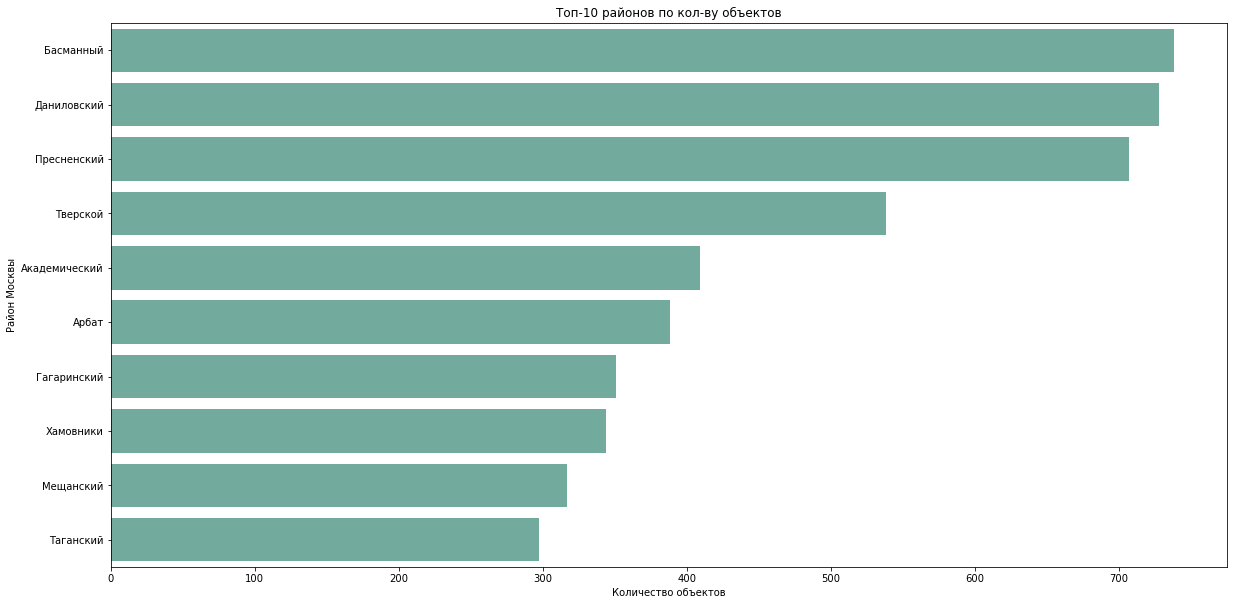

In [58]:
# Устанавливаем размер графика
plt.figure(figsize=(20, 10))

# Строим barplot
a = sns.barplot(
    x="id", 
    y='reg_name',
    data= top_reg,
    color='#69b3a2',
    ci=None)

# Название графика и осей
a.set_title("Топ-10 районов по кол-ву объектов")
a.set_ylabel("Район Москвы")
a.set_xlabel('Количество объектов')

Также находим топ округов

In [59]:
top_dist = upd_rest_data.groupby('dist_name')['id'].count().sort_values(ascending=False).to_frame().reset_index()
top_dist

,dist_name,id
0,ЦАО,3966
1,ЮАО,1895
2,ЮЗАО,1586
3,СВАО,1483
4,САО,1444
5,ВАО,1198
6,ЗАО,1124
7,ЮВАО,927
8,СЗАО,779
9,ЗелАО,252


Text(0.5, 0, 'Количество объектов')

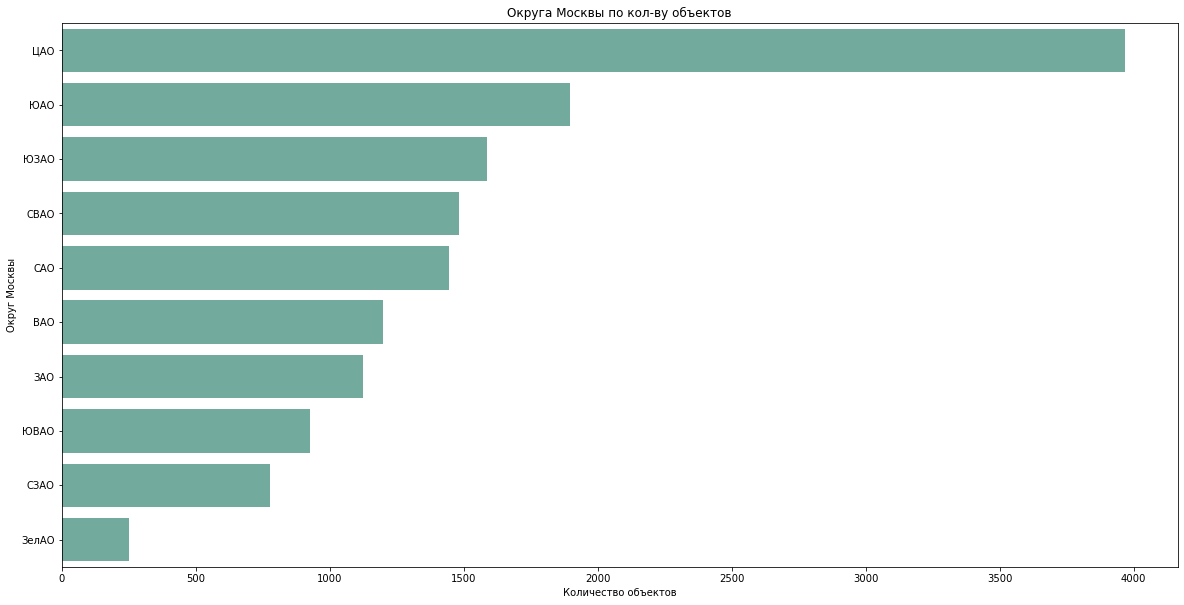

In [60]:
# Устанавливаем размер графика
plt.figure(figsize=(20, 10))

# Строим barplot
a = sns.barplot(
    x="id", 
    y='dist_name',
    data= top_dist,
    color='#69b3a2',
    ci=None)

# Название графика и осей
a.set_title("Округа Москвы по кол-ву объектов")
a.set_ylabel("Округ Москвы")
a.set_xlabel('Количество объектов')

### Топ 10 улиц + район и округ Москвы

Группируем датафрейм по улицам. Находим какое количество заведений относится к конкретной улице, сортируем по убыванию и выводим топ-10.

In [61]:
top10_streets = upd_rest_data.groupby('street')['id'].count().sort_values(ascending=False).reset_index().head(10)
top10_streets

,street,id
0,проспект Мира,203
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,город Зеленоград,131
7,проспект Вернадского,128
8,Кутузовский проспект,114
9,Каширское шоссе,111


Text(0.5, 1.0, 'Топ-10 улиц по количеству объектов общественного питания')

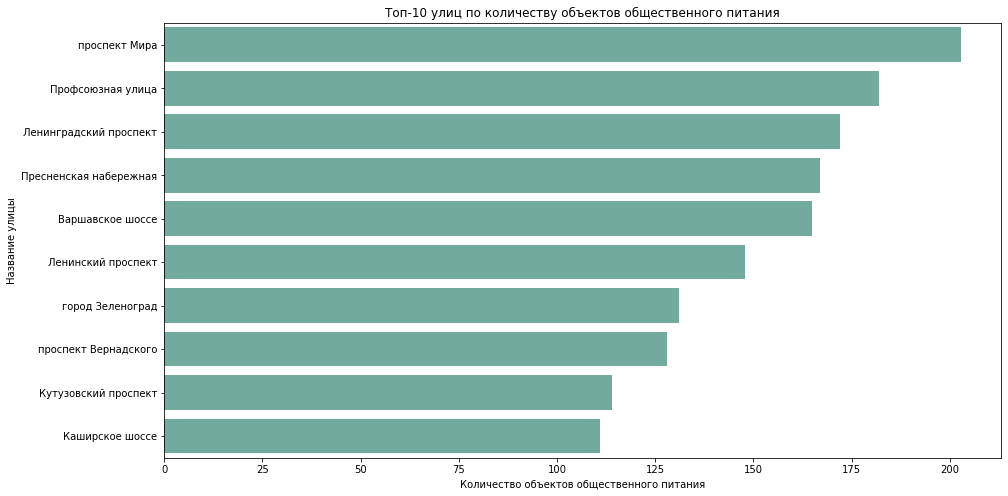

In [62]:
plt.figure(figsize=(15, 8))

top10 = sns.barplot(x='id', y='street', data=top10_streets, color='#69b3a2')

top10.set_xlabel('Количество объектов общественного питания')
top10.set_ylabel('Название улицы')
top10.set_title('Топ-10 улиц по количеству объектов общественного питания')

Объединим топ-10 улиц с нашим датафреймом, оставляя только топ-10 улиц, чтобы понять к каким районам и округам относятся эти улицы

In [63]:
top10 = top10_streets.merge(upd_rest_data_all_reg, how='left', on='street')
top10.head()

,street,id_x,id_y,object_name,chain,object_type,address,number,int_chains,clean_street,street_name,reg_link,dist_name,reg_name,reg_number
0,проспект Мира,203,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,0,мира,"Мира, проспект",http://mosopen.ru/region/alekseevskij/streets,СВАО,Алексеевский,8.0
1,проспект Мира,203,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,0,мира,"Мира, улица",http://mosopen.ru/region/vnukovo/streets,ЗАО,Внуково,8.0
2,проспект Мира,203,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,0,мира,"Мира, проспект",http://mosopen.ru/region/marina_roshcha/streets,СВАО,Марьина роща,8.0
3,проспект Мира,203,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,0,мира,"Мира, проспект",http://mosopen.ru/region/meshchanskij/streets,ЦАО,Мещанский,8.0
4,проспект Мира,203,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,0,мира,"Мира, проспект",http://mosopen.ru/region/ostankinskij/streets,СВАО,Останкинский,8.0


In [64]:
top10.groupby('street')['reg_name'].unique().reset_index()

,street,reg_name
0,Варшавское шоссе,"[Бутово Северное, Бутово Южное, Донской, Нагат..."
1,Каширское шоссе,"[Москворечье-Сабурово, Нагатино-Садовники, Оре..."
2,Кутузовский проспект,"[Дорогомилово, Фили-Давыдково]"
3,Ленинградский проспект,"[Аэропорт, Беговой, Сокол, Хорошёвский]"
4,Ленинский проспект,"[Гагаринский, Донской, Ломоносовский, Обручевс..."
5,Пресненская набережная,[Пресненский]
6,Профсоюзная улица,"[Академический, Коньково, Обручевский, Тёплый ..."
7,город Зеленоград,"[Крюково, Матушкино, Савёлки, Силино, Старое К..."
8,проспект Вернадского,"[Гагаринский, Ломоносовский, Проспект Вернадск..."
9,проспект Мира,"[Алексеевский, Внуково, Марьина роща, Мещански..."


### Топ-10 из коротких улиц

In [65]:
top10_streets_upd = upd_rest_data[upd_rest_data['reg_number'] == 1].groupby('street')['id'].count().sort_values(ascending=False).reset_index().head(10)
top10_streets_upd

,street,id
0,Пресненская набережная,167
1,Ходынский бульвар,102
2,улица Новый Арбат,92
3,улица Ленинская Слобода,89
4,Пятницкая улица,80
5,улица Покровка,77
6,улица Арбат,77
7,Ярославское шоссе,65
8,Хорошёвское шоссе,63
9,улица Маросейка,60


In [66]:
top10_upd = top10_streets_upd.merge(upd_rest_data_all_reg, how='left', on='street')
top10_upd.head()

,street,id_x,id_y,object_name,chain,object_type,address,number,int_chains,clean_street,street_name,reg_link,dist_name,reg_name,reg_number
0,Пресненская набережная,167,140422,ресторан «sixty»,нет,ресторан,"город Москва, Пресненская набережная, дом 12",300,0,пресненская,Пресненская набережная,http://mosopen.ru/region/presnenskij/streets,ЦАО,Пресненский,1.0
1,Пресненская набережная,167,156815,кафе «обедбуфет»,нет,буфет,"город Москва, Пресненская набережная, дом 10",237,0,пресненская,Пресненская набережная,http://mosopen.ru/region/presnenskij/streets,ЦАО,Пресненский,1.0
2,Пресненская набережная,167,58489,хлеб насущный,да,кафе,"город Москва, Пресненская набережная, дом 10",88,1,пресненская,Пресненская набережная,http://mosopen.ru/region/presnenskij/streets,ЦАО,Пресненский,1.0
3,Пресненская набережная,167,24296,гудман,да,ресторан,"город Москва, Пресненская набережная, дом 10",140,1,пресненская,Пресненская набережная,http://mosopen.ru/region/presnenskij/streets,ЦАО,Пресненский,1.0
4,Пресненская набережная,167,74554,старбакс,да,кафе,"город Москва, Пресненская набережная, дом 10",32,1,пресненская,Пресненская набережная,http://mosopen.ru/region/presnenskij/streets,ЦАО,Пресненский,1.0


In [67]:
top10_upd.groupby('street')['reg_name'].unique().reset_index()

,street,reg_name
0,Пресненская набережная,[Пресненский]
1,Пятницкая улица,[Замоскворечье]
2,Ходынский бульвар,[Хорошёвский]
3,Хорошёвское шоссе,[Хорошёвский]
4,Ярославское шоссе,[Ярославский]
5,улица Арбат,[Арбат]
6,улица Ленинская Слобода,[Даниловский]
7,улица Маросейка,[Басманный]
8,улица Новый Арбат,[Арбат]
9,улица Покровка,[Басманный]


In [68]:
top10dist2_upd = top10_upd.groupby('dist_name')['id_y'].count().sort_values(ascending=False).reset_index()
top10dist2_upd

,dist_name,id_y
0,ЦАО,553
1,САО,165
2,ЮАО,89
3,СВАО,65


Проделываем аналагичную процедуру для округов. 

In [69]:
top10dist = top10.groupby('street')['dist_name'].unique()
top10dist

street
Варшавское шоссе                    [ЮЗАО, ЮАО]
Каширское шоссе                           [ЮАО]
Кутузовский проспект                      [ЗАО]
Ленинградский проспект                    [САО]
Ленинский проспект        [ЮЗАО, ЮАО, ЗАО, ЦАО]
Пресненская набережная                    [ЦАО]
Профсоюзная улица                        [ЮЗАО]
город Зеленоград                        [ЗелАО]
проспект Вернадского                [ЮЗАО, ЗАО]
проспект Мира                  [СВАО, ЗАО, ЦАО]
Name: dist_name, dtype: object

In [70]:
top10dist2 = top10.groupby('dist_name')['id_y'].count().sort_values(ascending=False).reset_index()
top10dist2

,dist_name,id_y
0,ЮЗАО,2270
1,ЮАО,1582
2,ЗАО,1339
3,СВАО,1218
4,САО,688
5,ЗелАО,655
6,ЦАО,518


Отобразим, в каких округах находится топ-10 улиц по кол-ву объектов

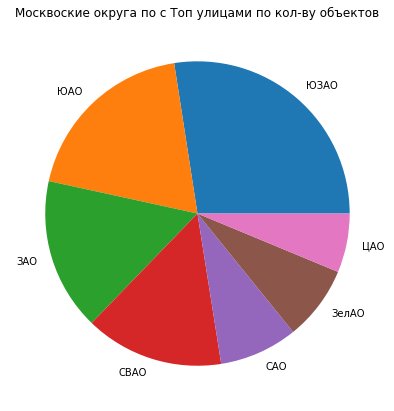

In [86]:
plt.figure(figsize=(7, 7))

# Create a pieplot
pie = plt.pie(top10dist2['id_y'], labels=top10dist2['dist_name'])
plt.title('Москвоские округа по с Топ улицами по кол-ву объектов')
plt.show()


**Вывод**

*Парсинг данных:*

1. Собрали информацию об улицах с разбивкой по районам и округам Москвы с сайта с открытыми данными MosOpen.ru. Для получения данных с веб страницы использовали пакет BeautifulSoup. Добавили информацию о районах и округах в датасет. 

2. Изучили топ районов и округов по кол-ву объектов. Больше всего заведений находится в ЦАО (более 7 тыс), ЮАО (5тыс) и ЮЗАО (4 тыс). Соответсвенно среди районов также лидируют те, которые находятся в центральном и южных округах - Тверской, Басманный, Даниловский,	Пресненский, Мещанский	


*Топ-10 улиц по кол-ву объектов:*

1. Применив группировку по улицам, нашли Топ-10 улиц с наибольшим количеством объектов общественного питания:
      * проспект Мира	
      * Варшавское шоссе
      * Ленинский проспект
      * Профсоюзная улица
      * Ленинградское шоссе
      * Дмитровское шоссе
      * Ленинградский проспект
      * город Зеленоград
      * проспект Вернадского
      * Кутузовский проспект
       
2. Нашли список районов, к которым относится наш топ-10 улиц. Отобразим топ10 районов, так как одна улица может относиться сразу к нескольким районам

      * Дорогомилово
      * Обручевский
      * Тёплый Стан
      * Донской
      * Ломоносовский
      * Нагатино-Садовники
      * Гагаринский
      * Проспект Вернадского
      * Тропарёво-Никулино
      * Чертаново Южное
      
3. Список округов, к которым относятся топ-10 улиц следующий

      * ЮЗАО
      * ЮАО
      * ЗАО
      * СВАО
      * САО
      * ЦАО
      
Можем заметить, что список округов для всего датасета и топ-10 улиц координально отличается. топ-10 улиц в меньшей степени затрагивают центральный округ
      

## Количество улиц с одним объектом общественного питания + район

Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Сгруппировали датасет по улицам, нашли сколько на каждой улице объектов. 
Сделали срез оставив только улицы с 1 объектом. Всего таких улиц - 403 

In [72]:
streets_by_id_num = upd_rest_data.groupby('street')['id'].count().reset_index().sort_values(by='id')
streets_by_id_num = streets_by_id_num[streets_by_id_num['id'] == 1].reset_index(drop=True)
streets_by_id_num['street'].count()

570

Получаем нужный срез с помощью мерджа двух датафреймов

In [73]:
lonely_streets = streets_by_id_num.merge(upd_rest_data, how='left', on='street')
lonely_streets.head()

,street,id_x,id_y,object_name,chain,object_type,address,number,int_chains,clean_street,street_name,reg_link,dist_name,reg_name,reg_number
0,Тетеринский переулок,1,29172,пу 33,нет,столовая,"город Москва, Тетеринский переулок, дом 2А",100,0,тетеринский,Тетеринский переулок,http://mosopen.ru/region/taganskij/streets,ЦАО,Таганский,1.0
1,улица Кутузова,1,23728,столовая гбоу города москвы № 1400,нет,столовая,"город Москва, улица Кутузова, дом 20",120,0,кутузова,"Кутузова, улица",http://mosopen.ru/region/mozhajskij/streets,ЗАО,Можайский,1.0
2,улица Кубинка,1,23750,столовая гбоу города москвы № 1400,нет,столовая,"город Москва, улица Кубинка, дом 20, корпус 1",200,0,кубинка,"Кубинка, улица",http://mosopen.ru/region/mozhajskij/streets,ЗАО,Можайский,1.0
3,Русаковская набережная,1,144462,кафе при азс газпромнефть №134,нет,буфет,"город Москва, Русаковская набережная, дом 7",18,0,русаковская,Русаковская улица,http://mosopen.ru/region/krasnoselskij/streets,ЦАО,Красносельский,3.0
4,улица Крутицкий Вал,1,29407,школа 469,нет,столовая,"город Москва, улица Крутицкий Вал, дом 5",240,0,крутицкий вал,"Крутицкий Вал, улица",http://mosopen.ru/region/yuzhnoportovyj/streets,ЮВАО,Южнопортовый,1.0


In [74]:
lonely_reg = lonely_streets.groupby('reg_name')['id_y'].count().sort_values(ascending=False).to_frame().reset_index().head(10)
lonely_reg

,reg_name,id_y
0,Басманный,25
1,Таганский,24
2,Хамовники,21
3,Арбат,19
4,Тверской,18
5,Пресненский,16
6,Марьина роща,16
7,Мещанский,15
8,Даниловский,14
9,Лефортово,12


In [75]:
lonely_dist = lonely_streets.groupby('dist_name')['id_y'].count().sort_values(ascending=False).to_frame().reset_index().head(10)
lonely_dist

,dist_name,id_y
0,ЦАО,167
1,СВАО,62
2,ВАО,55
3,САО,51
4,ЮВАО,50
5,ЗАО,43
6,ЮЗАО,28
7,СЗАО,25
8,ЮАО,25
9,ЗелАО,3


In [76]:
#fig = px.bar(dist_with_lonely_st, x='street', y='district')
#fig.show()

Text(0.5, 1.0, 'Округа с наибольшим кол-ом улиц с единственным объектом общественного питания')

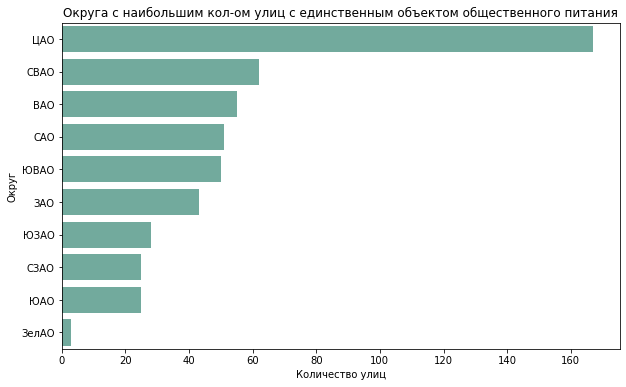

In [77]:
plt.figure(figsize=(10, 6))

fig_dist_with_lonely_st = sns.barplot(x='id_y', y='dist_name', data=lonely_dist, color='#69b3a2')

fig_dist_with_lonely_st.set_xlabel('Количество улиц')
fig_dist_with_lonely_st.set_ylabel('Округ')
fig_dist_with_lonely_st.set_title('Округа с наибольшим кол-ом улиц с единственным объектом общественного питания')

Text(0.5, 1.0, 'Районы с наибольшим кол-ом улиц с единственным объектом общественного питания')

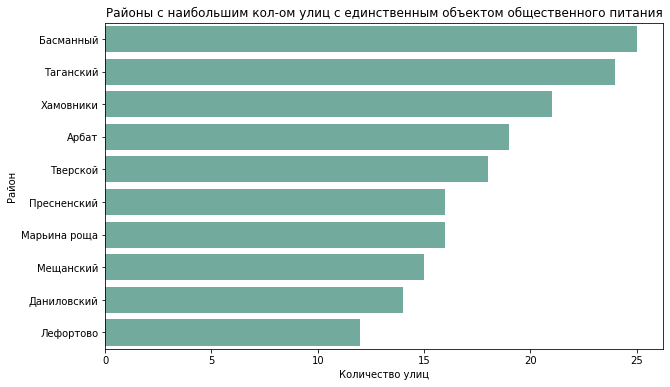

In [78]:
plt.figure(figsize=(10, 6))

fig_dist_with_lonely_st = sns.barplot(x='id_y', y='reg_name', data=lonely_reg, color='#69b3a2')

fig_dist_with_lonely_st.set_xlabel('Количество улиц')
fig_dist_with_lonely_st.set_ylabel('Район')
fig_dist_with_lonely_st.set_title('Районы с наибольшим кол-ом улиц с единственным объектом общественного питания')

**Вывод**

Всего в Москве 403 улицы, на которых расположен единственный объект общественного питания. 

Основные районы с улицами-одиночками:
   * Басманный
   * Таганский
   * Хамовники
   * Пресненский
   * Тверской
   
Основные округа с улицами-одиночками:
   * ЦАО
   * СВАО
   * ВАО
   * ЗАО
   * ЮВАО

## Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания
Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

Text(0.5, 1.0, 'Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания')

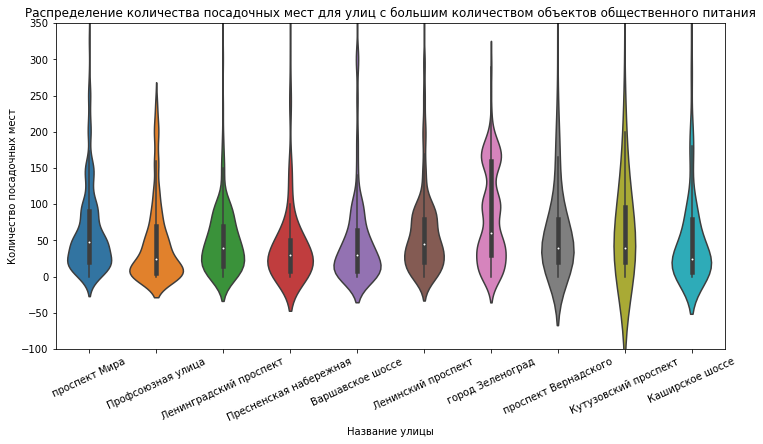

In [79]:
plt.figure(figsize=(12, 6))
plt.xticks(rotation=25)


distrib = sns.violinplot(x=top10['street'], y=top10['number'])

distrib.set_ylim(-100, 350)
distrib.set_xlabel('Название улицы')
distrib.set_ylabel('Количество посадочных мест')
distrib.set_title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания')


**Вывод**

Построили скрипичную диагрумму для топ-10 улиц по кол-ву посадочных мест.

   * На улицах возглавляющих Топ-10 наблюдается смещение в сторону заведений с меньшим кол-вом  посадочных мест
   * Чем ниже улица в топе, тем плавнее распределение

# Общий вывод

Проведено исследование рынка зведений общественного питания Москвы

Не новостью стала информация о большом количестве различных заведений общественного питания в Москве - **более 15тыс объектов**

Именно формат `кафе` является самым популярным на рынке - более 6тыс заведний, то есть **около 40% всех объектов**. Конкуренция высокая. 


**Сетевые заведения**

Доля сетевых заведений общественного питания в Москве составляет **около 20% от общего количества заведений**.
   * Медианное кол-во точек одной сети составляет **4 заведения**
   * Преобладают сети с малым кол-вом точек, но с большой посадкой
   
**Посадочные места**

   * Среднее кол-во посадочных мест для `кафе` составляет **40 шт**, для `кафетерия` всего **9**. Это стоит учитывать продумывая подробнее концепцию робокафе. Будет ли это именно кофейня (напитки, выпечка) или планируется полнценное кафе с кухней. 


**Местоположение**

Для начала изучили топ районов и округов по кол-ву объектов по общей выборке. Больше всего заведений находится в ЦАО (более 7 тыс), ЮАО (5тыс) и ЮЗАО (4 тыс). Соответсвенно среди районов также лидируют те, которые находятся в центральном и южных округах - Тверской, Басманный, Даниловский, Пресненский, Мещанский.	


1. *Топ-10 улиц по количеству об объектов общественного питания выглядят следующим образом:*
     >* проспект Мира	
     >* Варшавское шоссе
     >* Ленинский проспект
     >* Профсоюзная улица
     >* Ленинградское шоссе
     >* Дмитровское шоссе
     >* Ленинградский проспект
     >* город Зеленоград
     >* проспект Вернадского
     >* Кутузовский проспект
     
      
     Проверили, в каких округах и районах располагаются данные улицы. В отличие от общей выборки эти топ-10 улиц располагаются далеко не в центральном округе - ЮЗАО, ЮАО, ЗАО, СВАО, САО. 
     
     Заметим, что все улицы в этом списке довольно протяженные. Сюда также вошел целый пригород - Зеленоград. Вероятно, именно  поэтому на этих улицах может располагаться такое большое число заведений общественного питания. 
     

2. *Улицы с единственным заведением общественного питания*

    * Всего в Москве 403 улицы, на которых расположен единственный объект общественного питания.

    * Основные районы с улицами-одиночками - Басманный (23 улицы), Таганский (20), Хамовники (17), Пресненский (13), Тверской (12)  
    * Основные округа с улицами-одиночками. С большим отрывом лидирует ЦАО - 119 улиц. Также значительное количество таких улиц располагается в СВАО (40), ВАО (34), ЗАО (34) и ЮВАО (34)


**Итого:**
   * Наибольшее количество заведений находится в Центральном округе. Это можно объяснить тем, что там высокая проходимость. Именно в центре множество гуляющих граждан, туристов. Обратная сторона медали заключается в том, что конкуренция в центральных районах очень высока + аренда высока. Сложно привлечь аудиторию именно к вашему заведению. Обратите внимание на улицы с одиночными заведениями
   
   * Предлагаю обратить внимание на те округа, где на данный момент меньше заведений - северные и восточные районы. Подробнее изучить эти районы, найти подходящие локации с более высокой проходимостью. 
   
   * Расчитывайте кол-во посадочных мест исходя их типа объекта. В среднем для кафе 40 мест, для кафетерия 9. 
   
   

**Дальнейшие этапы исследования**

   * Подробнее продумать аудиторию заведения, и где в серверных/восточных районах города эту аудиторию можно найти
   
   * Подробнее изучить адреса заведений в особенности транспортную доступность в северных и восточных районах: 
      
       * Есть ли поблизости остановки общественного транспорта, метро
       * Есть ли место для парковки 

   * Подробнее изучить места расположения сетевых заведений. Проверить гипотезу, о том что лучше избегать расположения нового кафе пососедству со скоплением сетевых заведений:
   > Узнаваемость сетевых заведений заведомо высокая. Поэтому можно выдвинуть гипотезу о том, что типичный прохожий отдаст предпочтение одному из знакомых заведений. И в таком случае уровень посещаемости случайных прохожих будет низок. 
   
   
   
   
   

Ссылка на презентацию: https://drive.google.com/file/d/1uScWVRkrkmvA15K6tDSYGMYRphW_rB_t/view?usp=sharing